<a href="https://colab.research.google.com/github/Fatimakhanim/Deep-Learning-Projects/blob/main/04_transfer_learning_feature_extraction_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-07-26 15:42:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2024-07-26 15:42:31 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
with zipfile.ZipFile("/content/10_food_classes_10_percent.zip") as zip_ref:
  zip_ref.extractall()


(-0.5, 511.5, 511.5, -0.5)

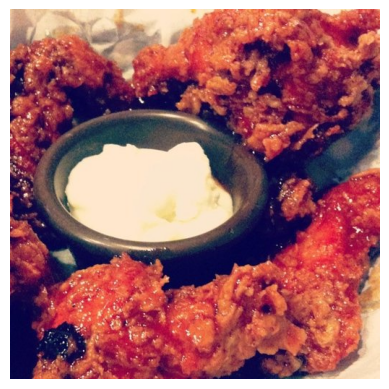

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/10_food_classes_10_percent/train/chicken_wings/1022742.jpg')
imgplot=plt.imshow(img)
plt.axis(False)

In [ ]:
import os
for (dirpath,dirnames,filenames) in os.walk('/content/10_food_classes_10_percent'):
  print(f"there are {len(dirpath)} directories and {len(filenames)} images in{dirpath}")

there are 35 directories and 0 images in/content/10_food_classes_10_percent
there are 41 directories and 0 images in/content/10_food_classes_10_percent/train
there are 47 directories and 75 images in/content/10_food_classes_10_percent/train/pizza
there are 51 directories and 75 images in/content/10_food_classes_10_percent/train/hamburger
there are 47 directories and 75 images in/content/10_food_classes_10_percent/train/sushi
there are 47 directories and 75 images in/content/10_food_classes_10_percent/train/steak
there are 55 directories and 75 images in/content/10_food_classes_10_percent/train/chicken_curry
there are 55 directories and 75 images in/content/10_food_classes_10_percent/train/chicken_wings
there are 47 directories and 75 images in/content/10_food_classes_10_percent/train/ramen
there are 51 directories and 75 images in/content/10_food_classes_10_percent/train/ice_cream
there are 52 directories and 75 images in/content/10_food_classes_10_percent/train/fried_rice
there are 56

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical"
                                               )

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical"
                                               )

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
for folder in os.listdir(train_dir):
  print(folder)

pizza
hamburger
sushi
steak
chicken_curry
chicken_wings
ramen
ice_cream
fried_rice
grilled_salmon


<ipython-input-7-af0733ced967>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,n)


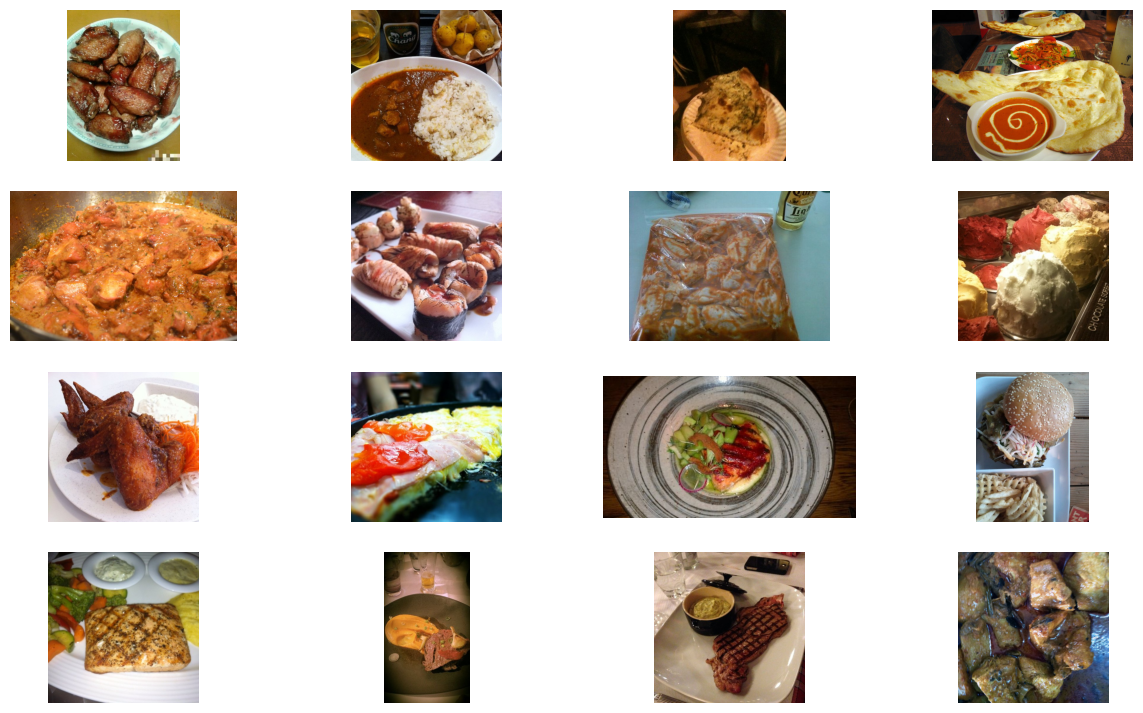

In [ ]:
import random
from PIL import Image

images = []
for folder in os.listdir(train_dir):
  for image in os.listdir(train_dir + "/" + folder):
    images.append(os.path.join(train_dir,folder,image))

plt.figure(1,figsize = (15,9))
plt.axis("off")
n = 0
for i in range(16):
  n+= 1
  random_img = random.choice(images)
  imgs = mpimg.imread(random_img)
  plt.subplot(4,4,n)
  plt.axis("off")
  plt.imshow(imgs)

plt.show()

In [ ]:
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2'
efficientnet_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

In [ ]:
def create_model(model_url , num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "Feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE +(3,))

  model = tf.keras.Sequential([
     feature_extractor_layer,
     tf.keras.layers.Dense(num_classes , activation = "softmax",name = "output_layer")
  ])
  return model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.layers[0]

In [ ]:
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard files to {log_dir}')
  return tensorboard_callback

In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  batch_size = BATCH_SIZE,
                                  epochs = 8,
                                  validation_data = test_data,
                                  steps_per_epoch = len(train_data),
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")] )

Saving Tensorboard files to tensorflow_hub/resnet50V2/20240726-154254
Epoch 1/8
24/24 [==============================] - 32s 764ms/step - loss: 1.8933 - accuracy: 0.3587 - val_loss: 1.1970 - val_accuracy: 0.6124
Epoch 2/8
24/24 [==============================] - 11s 477ms/step - loss: 0.8979 - accuracy: 0.7227 - val_loss: 0.8526 - val_accuracy: 0.7296
Epoch 3/8
24/24 [==============================] - 11s 487ms/step - loss: 0.6206 - accuracy: 0.8347 - val_loss: 0.7564 - val_accuracy: 0.7548
Epoch 4/8
24/24 [==============================] - 11s 470ms/step - loss: 0.4710 - accuracy: 0.8813 - val_loss: 0.7139 - val_accuracy: 0.7632
Epoch 5/8
24/24 [==============================] - 13s 539ms/step - loss: 0.3797 - accuracy: 0.9133 - val_loss: 0.6844 - val_accuracy: 0.7696
Epoch 6/8
24/24 [==============================] - 11s 454ms/step - loss: 0.3183 - accuracy: 0.9333 - val_loss: 0.6611 - val_accuracy: 0.7768
Epoch 7/8
24/24 [==============================] - 11s 477ms/step - loss: 0.25

In [ ]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6490 - accuracy: 0.7808


[0.6489550471305847, 0.7807999849319458]

In [ ]:
def plot_loss_curvers(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  #Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
efficientnet_model = create_model(
    model_url = efficientnet_url,
    num_classes = train_data.num_classes
)
efficientnet_model.compile(loss = "categorical_crossentropy",metrics = ["accuracy"],optimizer = tf.keras.optimizers.Adam())

history_efficientnet = efficientnet_model.fit(train_data,
                                              batch_size = BATCH_SIZE,
                                              epochs = 8,
                                              validation_data = test_data,
                                              steps_per_epoch = len(train_data),
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving Tensorboard files to tensorflow_hub/resnet50V2/20240726-154549
Epoch 1/8
24/24 [==============================] - 25s 595ms/step - loss: 1.8604 - accuracy: 0.4213 - val_loss: 1.3121 - val_accuracy: 0.7264
Epoch 2/8
24/24 [==============================] - 13s 540ms/step - loss: 1.0744 - accuracy: 0.7693 - val_loss: 0.8728 - val_accuracy: 0.8208
Epoch 3/8
24/24 [==============================] - 13s 547ms/step - loss: 0.7717 - accuracy: 0.8240 - val_loss: 0.7048 - val_accuracy: 0.8420
Epoch 4/8
24/24 [==============================] - 11s 451ms/step - loss: 0.6201 - accuracy: 0.8653 - val_loss: 0.6143 - val_accuracy: 0.8544
Epoch 5/8
24/24 [==============================] - 10s 446ms/step - loss: 0.5249 - accuracy: 0.8933 - val_loss: 0.5616 - val_accuracy: 0.8612
Epoch 6/8
24/24 [==============================] - 11s 455ms/step - loss: 0.4577 - accuracy: 0.9000 - val_loss: 0.5236 - val_accuracy: 0.8668
Epoch 7/8
24/24 [==============================] - 11s 452ms/step - loss: 0.40